In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load data 
data = pd.read_excel('Online Retail.xlsx')
# Explore data
#data.head()
#data.info()
# 541 909 rows but 406 829 rows of Customer ID, so drop rows w/o Customer ID 


In [56]:
# Drop rows that have no Customer IDs associated with them
data = data.dropna(subset=['CustomerID'])
#data.info() 
# There are now 406 829 rows for all the columns

In [5]:
# Create an invoice month in order to do the cohort analysis on a month level
import datetime as dt
# Write function for month that takes a date as input (x) and returns a new datetime object representing the first day of the same month.
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
# apply the function
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)
#data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01


In [8]:
# Create a column index with the minimum invoice date, aka first time customer was acquired
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')
#data.tail()
# The transform() function to ensure that the aggregated values are broadcasted back to the original DataFrame correctly. 
# It assign the minimum 'InvoiceMonth' value for each customer to a new column in the original DataFrame without losing the row-level alignment.


In [9]:
# Create a date element function to get a series for subtraction
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

In [11]:
# Get date elements for our cohort and invoice columns
_, invoice_month, invoice_year = get_date_elements(data, 'InvoiceMonth')
_, cohort_month, cohort_year = get_date_elements(data, 'CohortMonth')
# Check the (Series=1D column) first 10
#cohort_year[:10]

In [13]:
# Create a cohort index to show when a user was acquired. 
# Remember the cohort column was derived from (min invoice date) which is the first time they were active!
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
# To get the nr of months, when year diff is 1, then * by 12, then add any additional months to it
# and if the year diff is 0 and the month diff is 0, then the +1 represents that they were there for 1 month.
# This also takes into account the month in which they subscribed e.g. 2011-12-01 and 2011-08-01 (0*12=0+(12-8)=4+1=5months from August to Dec)
data['CohortIndex'] = year_diff*12+month_diff+1
#data.tail()
 

In [15]:
# Count customer ID by grouping by Cohort Month (when they were acquired) and cohortIndex (how long they've been active)
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
# .reset_index helps us avoid gaps when we pivot the table. It ensures we have a regular looking table.
# The code below also works, but the one above is more reliable.
#cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_data

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1.0,948
1,2010-12-01,2.0,362
2,2010-12-01,3.0,317
3,2010-12-01,4.0,367
4,2010-12-01,5.0,341
...,...,...,...
86,2011-10-01,2.0,93
87,2011-10-01,3.0,46
88,2011-11-01,1.0,321
89,2011-11-01,2.0,43


In [64]:
# Create a pivot table
cohort_table = cohort_data.pivot(index='CohortMonth', columns=['CohortIndex'], values='CustomerID')
cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortIndex', ylabel='CohortMonth'>

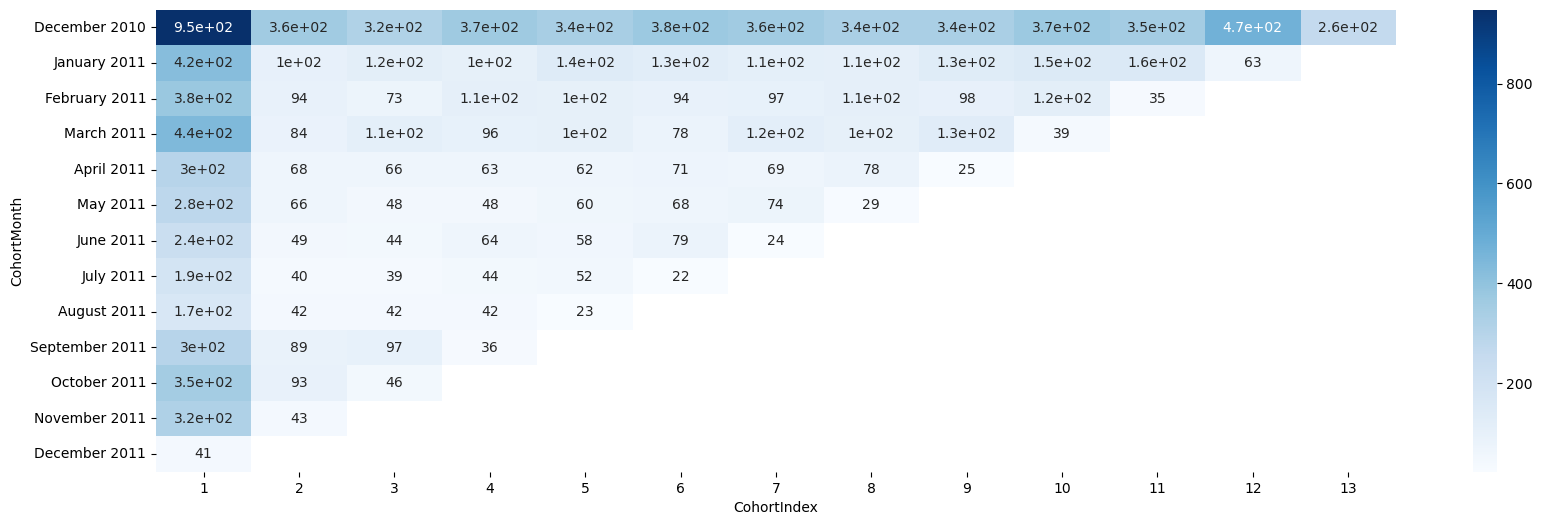

In [72]:
# Change index because it doesn't look nice --> 2010-02-01T00:00:00:0000000000 %B =Month, %Y=Year
#cohort_table.index = cohort_table.index.strftime('%B %Y') 
# Note: comment out the code above because it has already run once. If we run it again, it will throw an error becasue it's no longer a datetime object, so it's inactive.

# Visualize results in a heatmap
plt.figure(figsize=(20,6))
sns.heatmap(cohort_table, annot=True, cmap='Blues')

In [66]:
# Get percentages by dividing each row by the first column. The 1st column is 100%. That's the start, and the fullest it can be.
# Then it starts to wane and wax which is why you divide them by the first which is 100% to get the percentage of the whole that is still active. Save this as new_cohort_table.
new_cohort_table = cohort_table.divide(cohort_table.iloc[:, 0], axis=0)
new_cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='CohortIndex', ylabel='CohortMonth'>

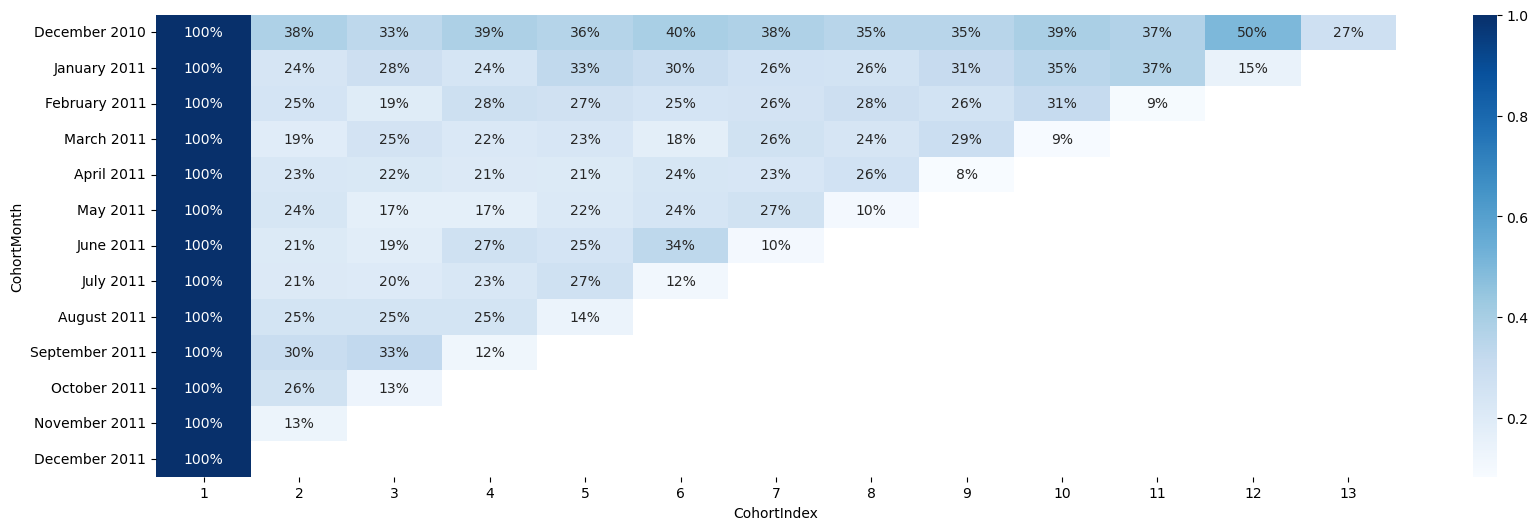

In [77]:
# Visualize new cohort table with percentages (formatted)
new_cohort_table.index = new_cohort_table.index.strftime('%B %Y')
plt.figure(figsize=(20,6))
sns.heatmap(new_cohort_table, annot=True, cmap='Blues', fmt='.0%')